In [3]:
%load_ext autoreload
%autoreload 2

In [4]:
import numpy as np
import scipy as sp
import matplotlib.pyplot as plt
import pandas as pd

In [5]:
from datafold.appfold import EDMD
from datafold.pcfold import PCManifold, InverseMultiquadricKernel, TSCDataFrame
from datafold.dynfold import DMDFull
from datafold.dynfold.transform import TSCRadialBasis

## Inverted pendulum Physics

In [6]:
from datafold.utils.kmpc import InvertedPendulum

## Data generation

In [7]:
# Data generation parameters
sim_time_step = 0.01  # s
sim_num_steps = 1000  # -
training_size = 20    # -

Different options exist about stacking the trajectories. We start with stacking them into one very long trajectory. (Also to consider reusing the final states, currently resetting to 0).

In [8]:
invertedPendulum = InvertedPendulum()

X = np.zeros((4, training_size*sim_num_steps))
Y = np.zeros((4, training_size*sim_num_steps))
U = np.zeros((1, training_size*sim_num_steps))
Xlist, Ulist = [], []
xycols = ['x', 'xdot', 'theta', 'thetadot']
np.random.seed(42)
for i in range(training_size):
    control_amplitude = 0.1 + 0.9*np.random.random() 
    control_frequency = np.pi + 2*np.pi*np.random.random()
    control_phase = 2*np.pi*np.random.random()
    control_func = lambda t,y: control_amplitude*np.sin(control_frequency*t + control_phase)
    invertedPendulum.reset()
    traj = invertedPendulum.trajectory(sim_time_step,
                                       sim_num_steps,
                                       control_func)
    assert invertedPendulum.sol.success, \
           f"Divergent solution for amplitude={control_amplitude}, frequency={control_frequency}"
    t = invertedPendulum.sol.t
    dfx = pd.DataFrame(data=traj.T, index=t, columns=xycols)
    dfx['u'] = 0.
    Xlist.append(dfx)
    control_input = control_func(t, traj)
    dfu = pd.DataFrame(data=control_input, index=t, columns=('u',))
    for col in xycols:
        dfu[col] = 0.
    dfu = dfu[xycols + ['u']]
    Ulist.append(dfu)

    X[:,i*sim_num_steps:(i+1)*sim_num_steps] = traj[:,:-1]
    Y[:,i*sim_num_steps:(i+1)*sim_num_steps] = traj[:,1:]
    U[:,i*sim_num_steps:(i+1)*sim_num_steps] = control_func(invertedPendulum.sol.t[:-1], traj[:,:-1])

XU = TSCDataFrame.from_frame_list(Xlist+Ulist)   

In [9]:
XU

feature          x      xdot     theta  thetadot         u
ID time                                                   
0  0.00   0.000000  0.000000  3.141593  0.000000  0.000000
   0.01  -0.000143 -0.028343  3.141110 -0.095568  0.000000
   0.02  -0.000562 -0.055111  3.139699 -0.185484  0.000000
   0.03  -0.001239 -0.080158  3.137421 -0.268933  0.000000
   0.04  -0.002158 -0.103345  3.134346 -0.345142  0.000000
...            ...       ...       ...       ...       ...
39 9.96   0.000000  0.000000  0.000000  0.000000 -0.276201
   9.97   0.000000  0.000000  0.000000  0.000000 -0.275695
   9.98   0.000000  0.000000  0.000000  0.000000 -0.274865
   9.99   0.000000  0.000000  0.000000  0.000000 -0.273712
   10.00  0.000000  0.000000  0.000000  0.000000 -0.272238

[40040 rows x 5 columns]

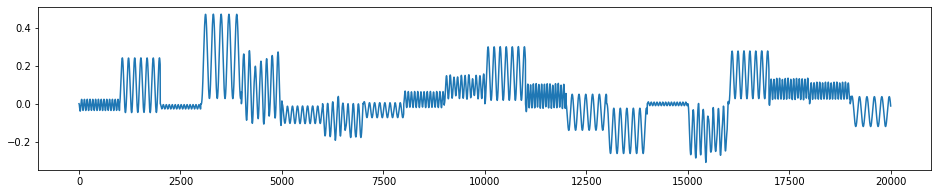

In [10]:
plt.figure(figsize=(16,3))
plt.plot(X[0].ravel())

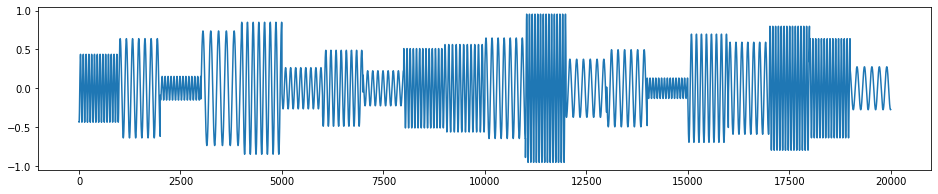

In [9]:
plt.figure(figsize=(16,3))
plt.plot(U[0].ravel())

## EDMD Predictor

In [11]:
num_rbfs = 100

In [12]:
from datafold.utils.kmpc import InverseQuadraticKernel